# Normal estimation based on covariance matrices

This notebook illustrates the extraction of normals from a set of points. For each point, a normal is estimated based on the other points in its vicinity. We first define simple tools to plot points and uniformly generate points on spheres.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

In [2]:
def rand_sphere(size, dim = 2):
    #normal distribution on every axis
    pts = np.random.normal(0,1,(size, dim))
    #uniform points on the sphere
    pts = pts / np.linalg.norm(pts, axis=1)[:, np.newaxis]
    return pts

def sq_distance(p1,p2):
    return (p1 - p2).dot(p1-p2)

Our test point set will be a 2D set of points initialized on a circle, with a little bit of added noise.

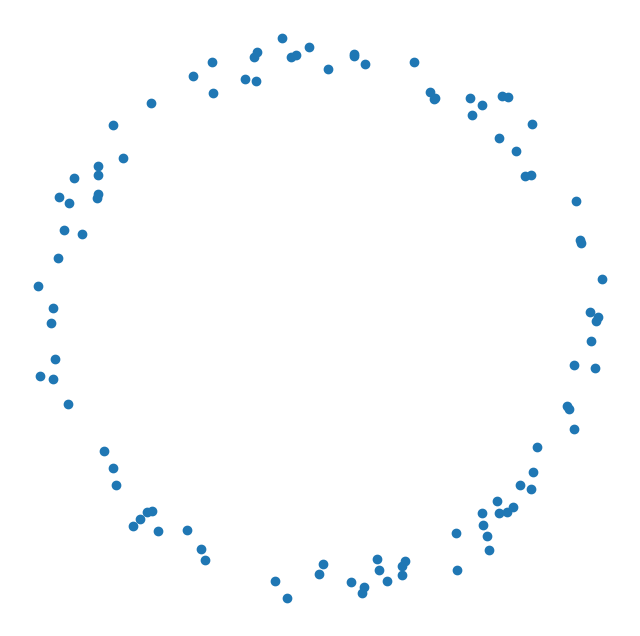

In [3]:
pts = rand_sphere(100)
pts += np.random.random(pts.shape) * 0.15

    
fig, ax = plt.subplots(figsize = (8,8))
ax.axis('off')

ax.scatter(pts[:,0], pts[:,1])

plt.show()

To locally define the normal at a point in space, we use its nearest neighbors. We provide below a naive implementation which linearly traverses the point set to get the k nearest neighbors of a given query point q. These points will be used to estimate the normal around the query point.

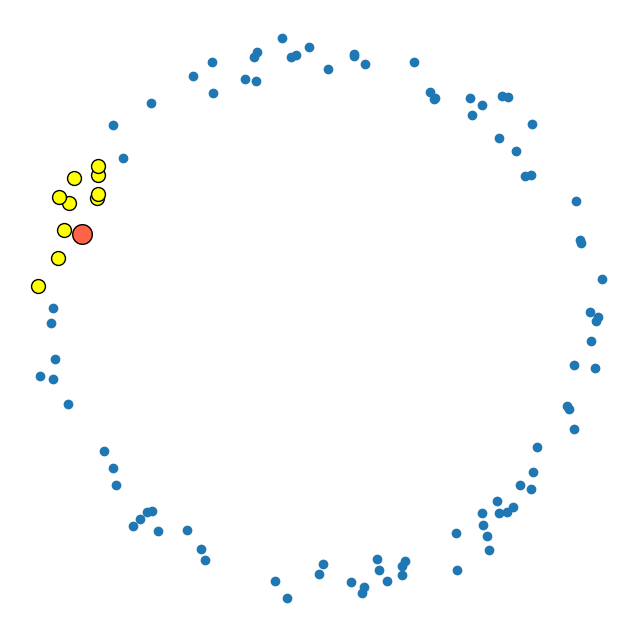

In [4]:
def neighbors(q, k, pts):
    diff = np.sum((pts - q)**2, axis=1)
    knn_id = np.argpartition(diff, range(k+1))
    return pts[knn_id[1:k+1]]

def neighbor_ids(q, k, pts):
    diff = np.sum((pts - q)**2, axis=1)
    knn_id = np.argpartition(diff, range(k+1))
    return knn_id[1:k+1]
    
fig, ax = plt.subplots(figsize = (8,8))
ax.axis('off')

ax.scatter(pts[:,0], pts[:,1])

q = pts[0]
knn = neighbors(q, 10, pts)

ax.scatter(knn[:,0], knn[:,1], color='yellow', s = 100, edgecolor='black')
ax.scatter([q[0]], [q[1]], color='tomato', s = 200, edgecolor='black')


plt.show()

From the set of nearest neighbors, a covariance matrix is built. This matrix can be seen in several ways. 

From a statistical point of view, this matrix generalizes the notion of variance to more than one dimension. In this formalism, the normal is the direction in which the neighbors have the smallest variance. This direction can be extracted from the matrix by looking at its smallest eigenvalue. The corresponding eigenvector is the estimated normal.

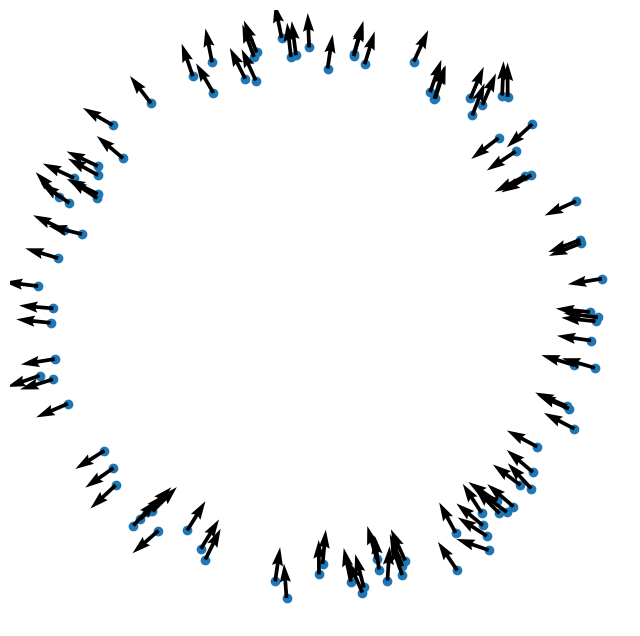

In [5]:
def normal(q, pts, k=10):
    nn = neighbors(q, k, pts)
    diff = nn - q
    M = diff.T.dot(diff)
    evals, evects = np.linalg.eig(M)
    i = np.argmin(evals)
    n = evects[:,i]
    return n / np.linalg.norm(n)

normals = np.array([normal(p, pts) for p in pts])

fig, ax = plt.subplots(figsize = (8,8))
ax.axis('off')

ax.scatter(pts[:,0], pts[:,1])
ax.quiver(pts[:,0], pts[:,1], normals[:,0], normals[:,1], angles='xy')


plt.show()

Another way to see the matrix is as that of a linear least squares minimization problem. In that case, the normal is defined as a vecteur which should be orthogonal to any segment joining the query point $\mathbf{q}$ and one of its neighbors $\mathbf{v}_i$. Each neighbor $\mathbf{v}_i$ therefore yields the linear equation $\mathbf{n}.(\mathbf{v}_i-\mathbf{q}) = 0$. The full system is described by a matrix where each line corresponds to one $(\mathbf{v}_i-\mathbf{q})^t$. Solving this system with linear least squares results in a linear system with the covariance matrix. this problem is however ill defined as the right hand side is $\mathbf{0}$, which therefore results in a trivial solution $\mathbf{n} = \mathbf{0}$. Non trivial solutions would be the null space of the matrix, but when the segments are not colinear, the matrix has no reason to be singular. Getting the smallest eigenvalue is therefore a good workaround.

Using the eigen vectors does not provide any guarantee with respect to the consistent orientation of the normals. A consistent orientation can be determined by using the [consistent tangent plane orientation (Hoppe at al. 92)](https://hhoppe.com/proj/recon/). This algorithm works as follows. Consider the k nearest neighbor graph we used to compute the normals. We want to propage the normal orientation along this graph. This can be naïvely done using any traversal of the graph, depth first for instance. However to improve consistency and avoid ambiguous situations, a good solution is to propagate in flat areas first. This can be done by weighting each edge of the graph between points $i$ and $j$ with a weight $1-\lvert \mathbf{n}_i.\mathbf{n}_j\rvert$. Computing a minimal spanning tree of this graph, and using this spanning for propagation will propagate using flat areas first.

In [6]:
def uf_find(uf, i):
    if i == uf[i]:
        return i
    uf[i] = uf_find(uf,uf[i])
    return uf[i]

def uf_merge(uf, i, j):
    pi = uf_find(uf,i)
    pj = uf_find(uf,j)
    uf[pi] = pj

def reorient_consistently(pts, normals, k=10):
    #build nearest neighbor graph
    graph = np.array([neighbor_ids(q, k, pts) for q in pts])

    #weight the edges by tangent plane consistency
    weights = np.array([1 - np.abs(normals[graph[i,:]].dot(normals[i])) for i in range(pts.shape[0])])

    #sort the edges by ascending weights
    order = np.argsort(weights, None)

    #minimum spanning tree (Kruskal)
    tree = [[] for _ in pts]
    uf = np.arange(pts.shape[0])
    for edge_index in order:
        (i,ni) = np.unravel_index(edge_index, graph.shape)
        j = graph[i,ni] ;
        pi = uf_find(uf, i)
        pj = uf_find(uf, j)
        if pi != pj:
            uf_merge(uf, pi, pj)
            tree[i].append(j)
            tree[j].append(i)

    #select the minimal x vertex as initial vertex for the traversal
    leftmost = np.argmin(pts, axis = 0)[0]

    #its normal should be oriented towards -x
    if normals[leftmost,0] > 0:
        normals[leftmost] = -normals[leftmost]

    #DFS the spanning tree
    stack = [leftmost]
    visited = [False for _ in pts]
    visited[leftmost] = True
    while len(stack) > 0:
        v = stack.pop()
        for n in tree[v]:
            if not visited[n]:
                visited[n] = True
                if normals[v].dot(normals[n]) < 0:
                    normals[n] = -normals[n]
                stack.append(n)


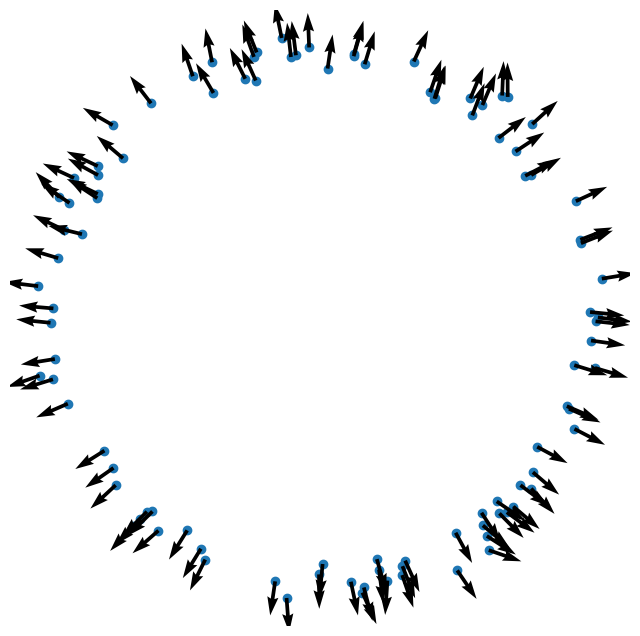

In [7]:
reorient_consistently(pts, normals)

fig, ax = plt.subplots(figsize = (8,8))
ax.axis('off')

ax.scatter(pts[:,0], pts[:,1])
ax.quiver(pts[:,0], pts[:,1], normals[:,0], normals[:,1], angles='xy')


plt.show()

In [8]:
suzanne_pts = np.load('suzanne_vertices.npy')

In [9]:
suzanne_pts = suzanne_pts[np.random.choice(np.arange(suzanne_pts.shape[0]), 4000)]

In [10]:
suzanne_normals = 0.07 * np.array([normal(p, suzanne_pts) for p in suzanne_pts])
reorient_consistently(suzanne_pts, suzanne_normals)

In [11]:
def turntable(fig, angle_step):  
    plt.close()
    
    def animate(i):
        fig.gca().view_init(30, (angle_step *i) % 360)
        fig.canvas.draw_idle()
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(360 / angle_step), interval = 100);
    return (HTML(ani.to_html5_video()))

fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection':'3d'})
ax.set_box_aspect([1,1,1])
ax.axis('off')

ax.scatter(suzanne_pts[:,0], suzanne_pts[:,1], suzanne_pts[:,2])


ax.quiver(
    suzanne_pts[:,0], suzanne_pts[:,1], suzanne_pts[:,2], 
    suzanne_normals[:,0], suzanne_normals[:,1], suzanne_normals[:,2], 
    color = 'black')

turntable(fig, 5)